# Autoencoder를 이용한 데이터 생성
---
- 시계열 Feature 종류 대비 짧은 시계열 길이(차원의 저주)  
> 고려할 수 있는 요소는 수십 - 수백개인데, 고려할 수 있는 데이터 길이는 너무 짧음
- 시계열 Feature 자체의 노이즈 
> TS denoising(Moving Average, Bilateral Filter...)
<!-- <img src = "https://www.researchgate.net/profile/Xavier-Hadoux/publication/278786166/figure/fig9/AS:613951482101777@1523388848382/Illustration-of-the-Curse-of-dimensionality-showing-how-the-number-of-regions-of-a.png" width="300px"> -->
  
   
    
==>   위의 두가지 문제로 인한 overfitting

<br> 
<br>

- 데이터로 비슷한 패턴의 데이터를 만드는 방법 사용 (Autoencoding)   
> 압축된 정보를 새로운 특성으로 활용(PCA와 같은 일차원 데이터 처리 방식을 확장한 것)  

<br> 

<img src = "https://miro.medium.com/max/675/1*_7qb8rMFu_BciKvZkTU-yg.png" width="500px">

In [117]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


1. Simple feed-forward autoencoder
2. Deep autoencoder
3. 1D Convolutional autoencoder
4. LSTM (recurrent neural networks) autoencoder
5. Simple AE + augmention with synthetic data
6. Deep autoencoder + synthetic data


## Parameters


In [83]:
startdate="01/01/2015"
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 2000

## Utils

In [84]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Datasets 
- coindesk dataset(https://www.coindesk.com/price/)
- 1 hour close price



In [85]:
# get data
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%d/%m/%Y").timetuple())
end_timestamp = int(time.time())
one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ",days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    s = req.Session()
    r = s.get("https://www.coindesk.com/price/")
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        r = s.get("https://api.coindesk.com/charts/data?data=close&startdate={}&enddate={}&exchanges=bpi&dev=1&index=USD".format(start_weekday, end_weekday))
        ans = json.loads(r.text.replace("cb(", "").replace(");",""))["bpi"]
        ans.sort(key=lambda x: x[0])
        for pricepoint in ans:
            if pricepoint[0]/1000 >= weeks[i-1] and pricepoint[0]/1000 < (weeks[i]-one_day):
                data.append([int(pricepoint[0]/1000), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))



days_recorded  2399


- 수익률 계산 함수: pct_change() 
- log_ret: 전일 가격으로 log 수익률 계산 

- 지정한 window_length(10) 길이 만큼 한 칸씩 이동하면서 데이터 구간을 나눔
- MinMaxScaler 적용

In [86]:
df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:] # test_samples: 2000
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


100%|██████████| 43410/43410 [00:00<00:00, 310437.04it/s]

100%|██████████| 43410/43410 [00:06<00:00, 7170.30it/s]


In [87]:
df.head()

,price,pct_change,log_ret
0,318.19,NaN,NaN
1,316.90,-0.004054,-0.004062
2,316.91,0.000032,0.000032
3,317.27,0.001136,0.001135
4,314.05,-0.010149,-0.010201


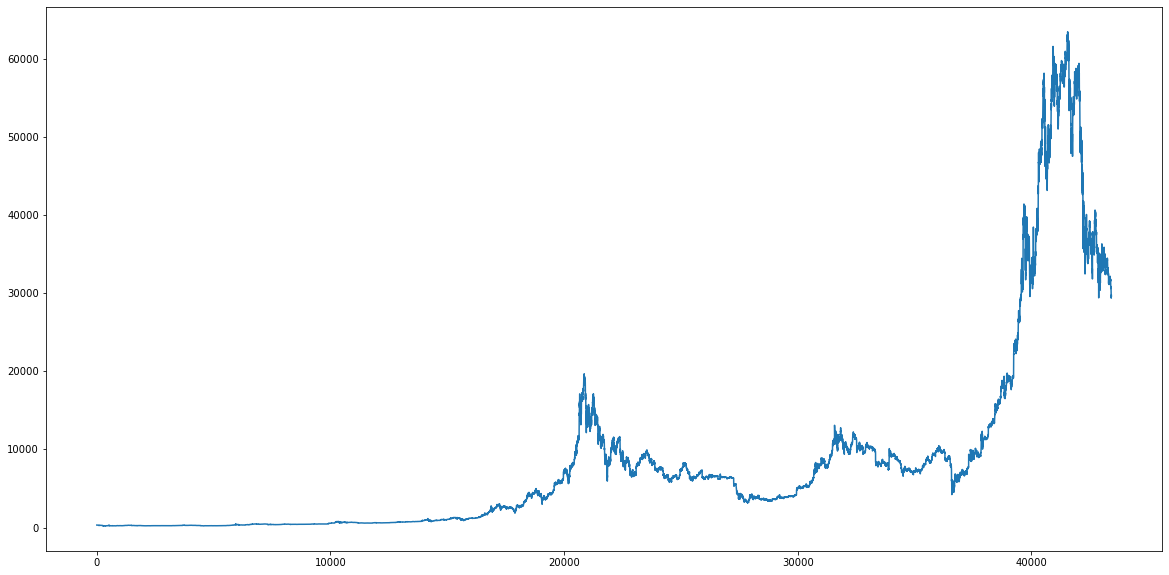

In [88]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

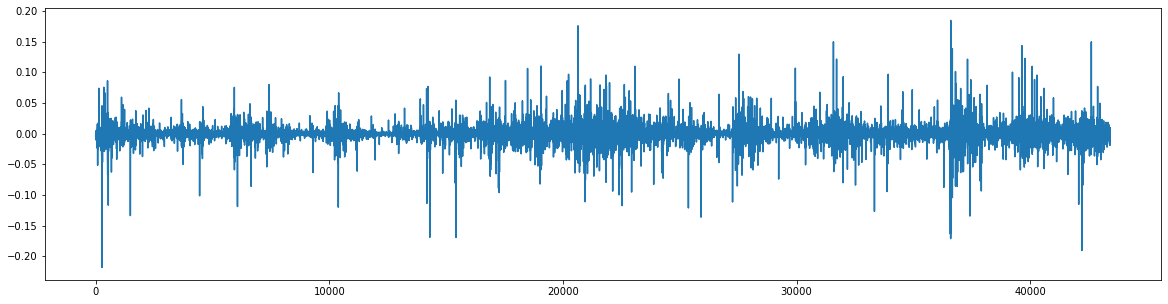

In [119]:
plt.figure(figsize=(20,5))
plt.plot(df['log_ret'])

In [90]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 4.829751267809708%


## Simple feed-forward autoencoder

In [91]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window) # dim 10 -> dim 3
decoded = Dense(window_length, activation='sigmoid')(encoded) # dim 3 -> dim 10

autoencoder = Model(input_window, decoded)

encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

########## new feature
compress_x_train = encoder.predict(x_train_simple)
compress_x_test = encoder.predict(x_test_simple)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_23 (Dense)             (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6916 - val_loss: 0.6892
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6884 - val_loss: 0.6850
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6842 - val_loss: 0.6798
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6791 - val_loss: 0.6

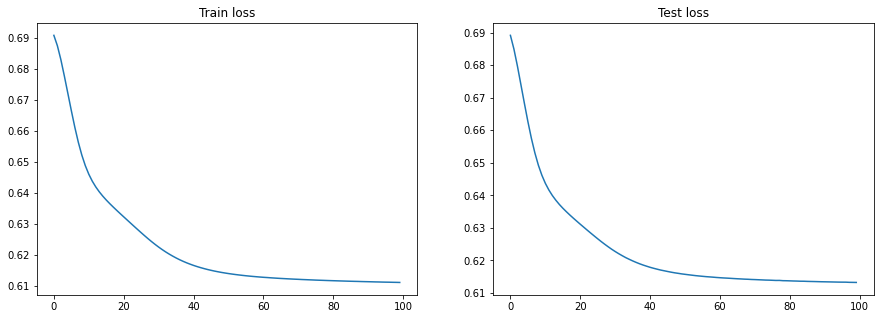

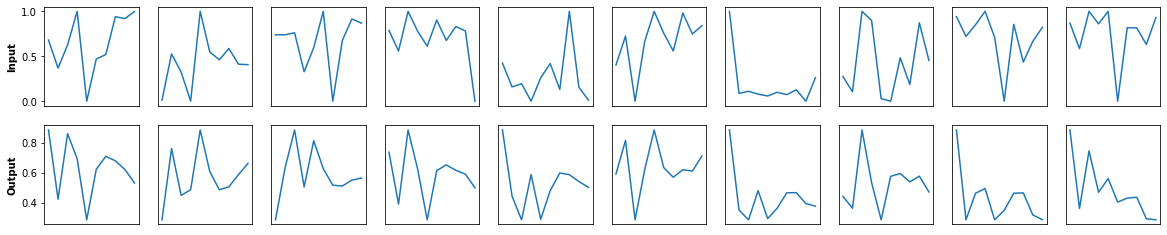

In [92]:
plot_history(history) # loss graph
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder
- 10 -> 6 -> 6 -> 3 -> 6 -> 6 -> 10
- 첫 모델과 다른 점은 BatchNormalization() 추가

In [93]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_6 (Batch (None, 6)                 24        
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_7 (Batch (None, 6)                 24        
_________________________________________________________________
dense_27 (Dense)             (None, 10)                70 

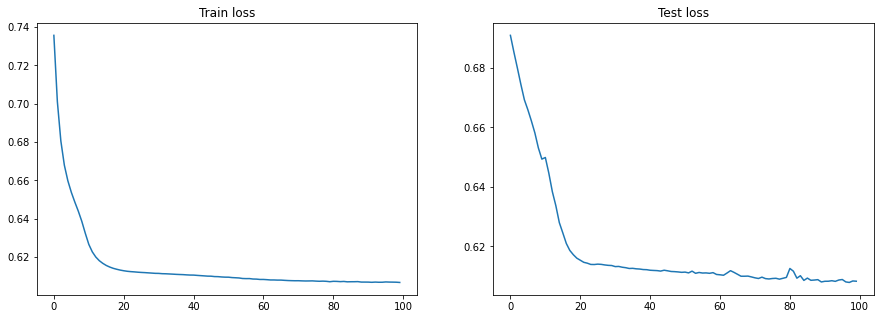

In [94]:
plot_history(history)

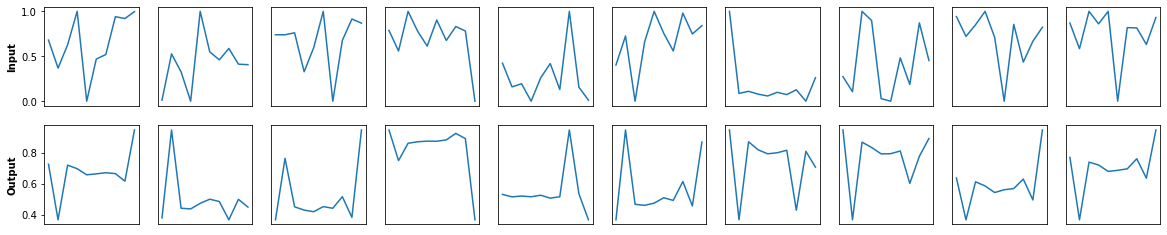

In [95]:
plot_examples(x_test_deep, decoded_stocks)

## 1D Convolutional autoencoder
- Conv1D() 이용

In [96]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer
x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)



Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_6 (UpSampling1 (None, 6, 1)              0  

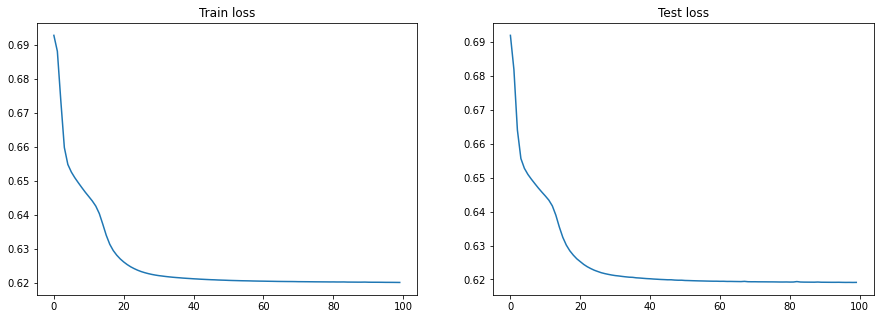

In [97]:
plot_history(history)

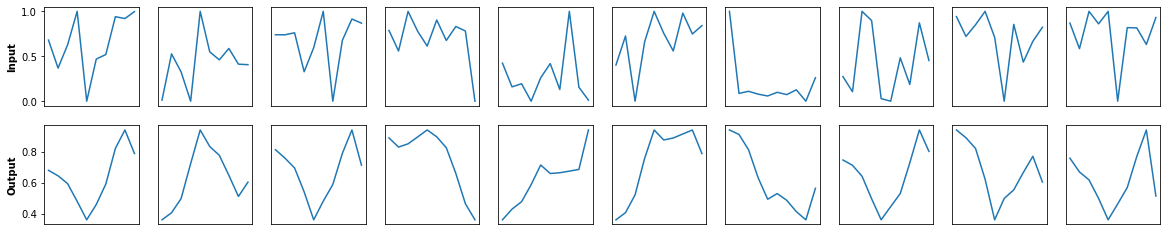

In [98]:
plot_examples(x_test_deep, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder
- LSTM은 시계열 처리에 적합 but.. autoencoder 성능은 낮음
- 임의의 sequence를 고정된 h(t) 매핑하기 때문


In [99]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3)                 60        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 10, 3)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 3s 21ms/step - loss: 7.7220 - val_loss: 7.7593
Epoch 2/100
41/41 [==============================] - 0s 8ms/step - loss: 7.7254 - val_loss: 7.7593
Epoch 3/100
41/41 [==============================] - 0s 7ms/s

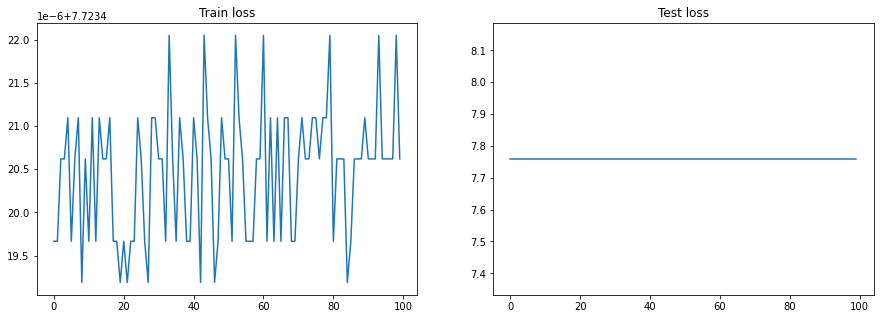

In [100]:
plot_history(history)

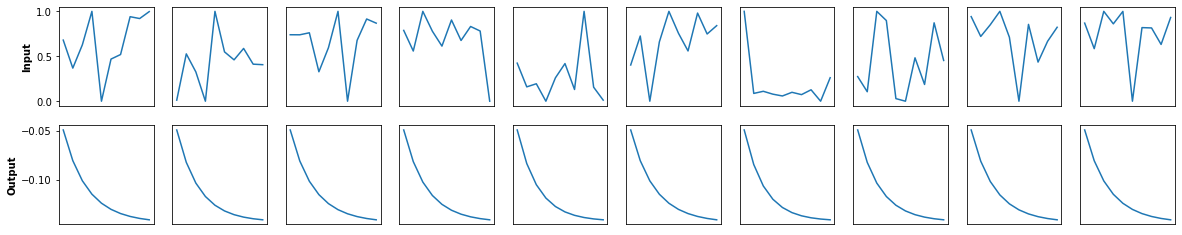

In [101]:
plot_examples(x_test, decoded_stocks)

## Simple AE + augmention with synthetic data
- MinMaxScaler 사용으로 10개의 범주에서 0~1 사이의 연속값
- 새로운 데이터 생성 <-- synthetic data
- 언더샘플링 된 공간의 데이터 일부를 이해하도록 train dataset에 추가

In [102]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)


100%|██████████| 100000/100000 [00:03<00:00, 27231.33it/s][A


In [103]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_29 (Dense)             (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
139/139 [==============================] - 1s 2ms/step - loss: 0.6997 - val_loss: 0.6875
Epoch 2/100
139/139 [==============================] - 0s 1ms/step - loss: 0.6797 - val_loss: 0.6701
Epoch 3/100
139/139 [==============================] - 0s 1ms/step - loss: 0.6628 - val_loss: 0.6569
Epoch 4/100
139/139 [==============================] - 0s 1ms/step - loss: 0.6515 - val_l

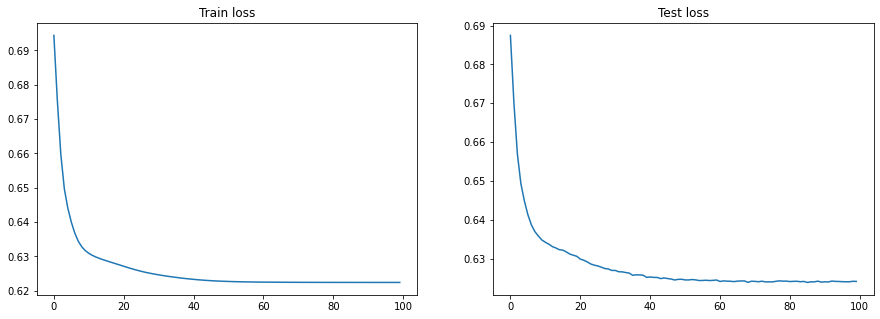

In [104]:
plot_history(history)

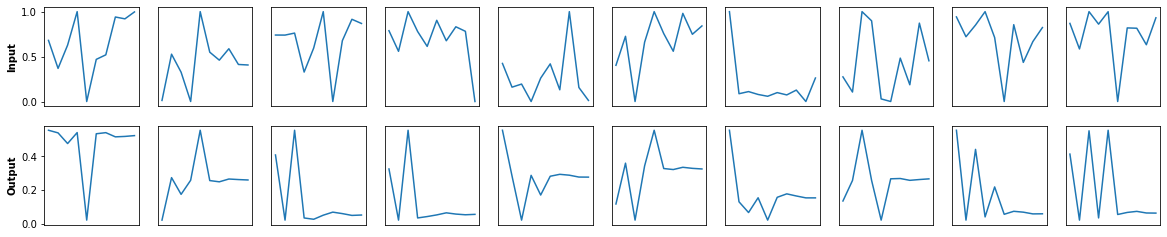

In [105]:
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder + synthetic data

In [106]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_8 (Batch (None, 6)                 24        
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_9 (Batch (None, 6)                 24        
_________________________________________________________________
dense_33 (Dense)             (None, 10)                70 

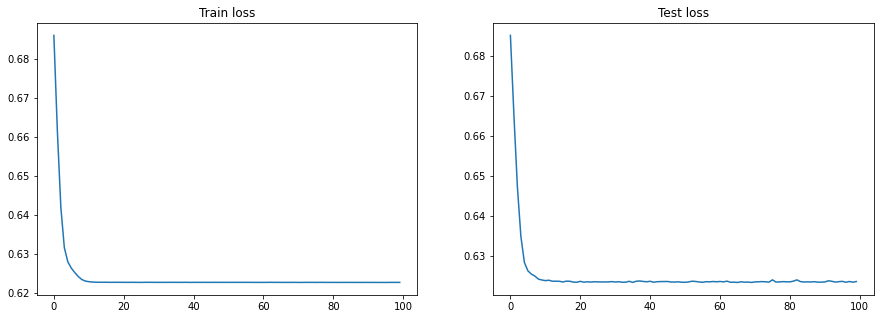

In [107]:
plot_history(history)

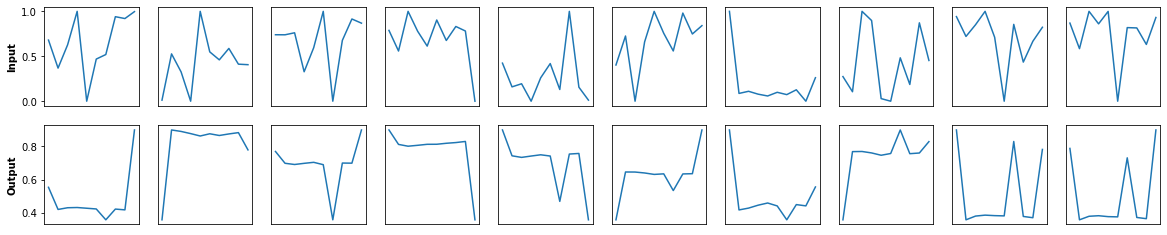

In [108]:
plot_examples(x_test_simple, decoded_stocks)

## Compress Dataframe

In [113]:
x_train_simple.shape, x_test_simple.shape

((141410, 10), (2000, 10))

In [114]:
new_feature = np.concatenate([compress_x_train, compress_x_test])
tmp_df = pd.DataFrame(new_feature, columns=['comp_fe1','comp_fe2','comp_fe3'])
tmp_df.head()

,comp_fe1,comp_fe2,comp_fe3
0,1.098234,2.792057,2.899299
1,3.658599,5.126752,4.150657
2,1.249040,3.950368,2.117958
3,0.582586,2.195696,3.059514
4,2.990239,3.695498,2.568361


In [115]:
tmp_df.shape

(43410, 3)